## PINN for 4D heat equation

#### Defining the problem:
$$\frac{d}{dt}u(\vec x,t)=\alpha\sum_{i=1}^4\frac{d^2}{dx_i^2}u(\vec x,t)$$

$$\vec x\in[0,1]^4$$

Initial and boundary conditions:

$$u(\vec x,0) = \sin(\pi x_1)\sin(2\pi x_2)\sin(\pi x_3)\sin(\pi x_4)$$

On boundaries, $u(\vec x,t)=0$.

#### Boundary conditions are enforced with a hard constraint:
* Model is defined as $u_\theta(x,t)=\left(\Pi_{i=1}^44x_i(1-x_i)\right)g_\theta(\vec x,t)$
* $g_\theta(\vec x,t)$ is a multilayer perceptron with parameters $\theta$.

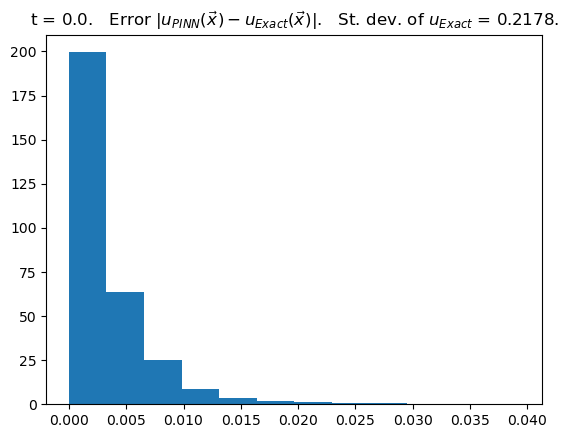

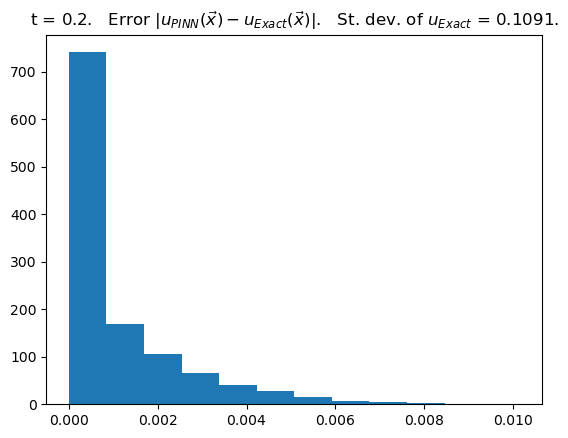

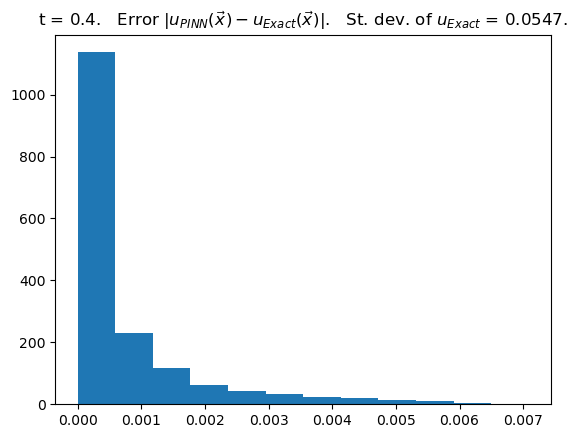

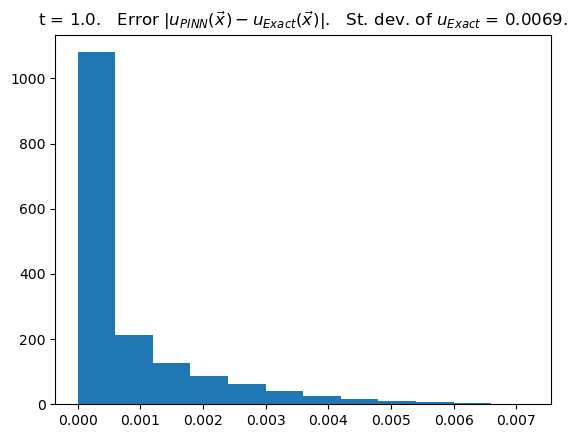

In [45]:
"""
- Evaluate PINN on 15x15x15x15 grid at four different values of t.
- Plot histogram of errors

"""


import torch
from model_architecture import PINN
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
pi = 3.1415926535898


def exact_solution(x_list, t):
    return torch.sin(pi*x_list[0])*torch.sin(2*pi*x_list[1])*torch.sin(pi*x_list[2])*torch.sin(pi*x_list[3])*torch.exp(-7*alpha*pi**2*t)

alpha = 0.05  # Thermal diffusivity
spatial_dim = 4

# Load PINN model
model = PINN(input_dim=spatial_dim+1)
model.load_state_dict(torch.load('weights1.pth'))

model.eval()
x1 = torch.linspace(0, 1, 15)
x2 = torch.linspace(0, 1, 15)
x3 = torch.linspace(0, 1, 15)
x4 = torch.linspace(0, 1, 15)
times = torch.tensor([0.0, 0.2, 0.4, 1.0])

X1, X2, X3, X4 = torch.meshgrid(x1, x2, x3, x4, indexing='ij')
#fig, ax = plt.subplots(4,1, figsize=(5,14))

for i, t in enumerate(times):
    T = t * torch.ones_like(X1)
    with torch.no_grad():
        U = model([X1.reshape(-1, 1), X2.reshape(-1, 1), X3.reshape(-1, 1), X4.reshape(-1, 1)], T.reshape(-1, 1)).reshape(X1.shape)

    U_exact = exact_solution([X1, X2, X3, X4], T)
    
    abs_diff = torch.abs(U - U_exact).flatten()
    std_exact = torch.std(U_exact)

    plt.figure()
    plt.hist(abs_diff, bins=12, density=True)
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.title(f't = {t.item():.1f}.' + r'   Error $|u_{PINN}(\vec x)-u_{Exact}(\vec x)|$.   St. dev. of $u_{Exact}$ = ' + f'{std_exact:.4f}.')
